<h2>First of all: Segmented CTE</h2>
How do we switch over from one segment (provided by A*) to the next while calculating Cross-Track-Error (CTE) in an attempt to apply PID to that.

Heuristics:  [[9, 8, 7, 6, 5, 4], [8, 7, 6, 5, 4, 3], [7, 6, 5, 4, 3, 2], [6, 5, 4, 3, 2, 1], [5, 4, 3, 2, 1, 0]]
A* path:  [[0, 0], [1, 0], [2, 0], [3, 0], [3, 1], [3, 2], [2, 2], [1, 2], [0, 2], [0, 3], [0, 4], [0, 5], [1, 5], [2, 5], [2, 4], [3, 4], [4, 4], [4, 5]]
Smoothed path:  [[0, 0], [1.1796490799484765, -0.027097786688960502], [2.229427696296309, 0.06528337202664698], [2.948424765953323, 0.38736163568256754], [3.136931576835533, 0.9422917128646766], [2.7888070895155517, 1.4794555343809026], [1.9822275370573637, 1.8063145881939435], [1.0185563224616838, 2.0614511340653325], [0.22164465051272253, 2.4838017711338676], [-0.17274735276941902, 3.2117262927684425], [-0.17285116861097255, 4.049063639575604], [0.1874922355330803, 4.685736111693432], [0.8609218037591869, 4.875012057930311], [1.626043544532527, 4.672826975872756], [2.3255365638759256, 4.299861268672558], [3.0179440913437166, 4.161534664331901], [3.599737992766264, 4.4112773969096075], [4, 5]]
[True, 0, 149]


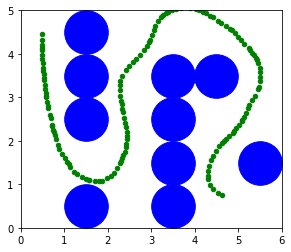

In [43]:
# -----------
# User Instructions
#
# Familiarize yourself with the code below. Most of it
# reproduces results that you have obtained at some
# point in this class. Once you understand the code,
# write a function, cte, in the run class that
# computes the crosstrack
# error for the case of a segmented path. You will
# need to include the equations shown in the video.
#
 
from math import *
import random


# don't change the noise paameters

steering_noise    = 0.1
distance_noise    = 0.03
measurement_noise = 0.3


class plan:

    # --------
    # init: 
    #    creates an empty plan
    #

    def __init__(self, grid, init, goal, cost = 1):
        self.cost = cost
        self.grid = grid
        self.init = init
        self.goal = goal
        self.make_heuristic(grid, goal, self.cost)
        self.path = []
        self.spath = []

    # --------
    #
    # make heuristic function for a grid
        
    def make_heuristic(self, grid, goal, cost):
        self.heuristic = [[0 for row in range(len(grid[0]))] 
                          for col in range(len(grid))]
        for i in range(len(self.grid)):    
            for j in range(len(self.grid[0])):
                self.heuristic[i][j] = abs(i - self.goal[0]) + \
                    abs(j - self.goal[1])



    # ------------------------------------------------
    # 
    # A* for searching a path to the goal
    #
    #

    def astar(self):


        if self.heuristic == []:
            raise Exception(ValueError, "Heuristic must be defined to run A*")

        # internal motion parameters
        delta = [[-1,  0], # go up
                 [ 0,  -1], # go left
                 [ 1,  0], # go down
                 [ 0,  1]] # do right


        # open list elements are of the type: [f, g, h, x, y]

        closed = [[0 for row in range(len(self.grid[0]))] 
                  for col in range(len(self.grid))]
        action = [[0 for row in range(len(self.grid[0]))] 
                  for col in range(len(self.grid))]

        closed[self.init[0]][self.init[1]] = 1


        x = self.init[0]
        y = self.init[1]
        h = self.heuristic[x][y]
        g = 0
        f = g + h

        open = [[f, g, h, x, y]]

        found  = False # flag that is set when search complete
        resign = False # flag set if we can't find expand
        count  = 0


        while not found and not resign:

            # check if we still have elements on the open list
            if len(open) == 0:
                resign = True
                print('###### Search terminated without success')
                
            else:
                # remove node from list
                open.sort()
                open.reverse()
                next = open.pop()
                x = next[3]
                y = next[4]
                g = next[1]

            # check if we are done

            if x == goal[0] and y == goal[1]:
                found = True
                # print '###### A* search successful'

            else:
                # expand winning element and add to new open list
                for i in range(len(delta)):
                    x2 = x + delta[i][0]
                    y2 = y + delta[i][1]
                    if x2 >= 0 and x2 < len(self.grid) and y2 >= 0 \
                            and y2 < len(self.grid[0]):
                        if closed[x2][y2] == 0 and self.grid[x2][y2] == 0:
                            g2 = g + self.cost
                            h2 = self.heuristic[x2][y2]
                            f2 = g2 + h2
                            open.append([f2, g2, h2, x2, y2])
                            closed[x2][y2] = 1
                            action[x2][y2] = i

            count += 1

        # extract the path



        invpath = []
        x = self.goal[0]
        y = self.goal[1]
        invpath.append([x, y])
        while x != self.init[0] or y != self.init[1]:
            x2 = x - delta[action[x][y]][0]
            y2 = y - delta[action[x][y]][1]
            x = x2
            y = y2
            invpath.append([x, y])

        self.path = []
        for i in range(len(invpath)):
            self.path.append(invpath[len(invpath) - 1 - i])




    # ------------------------------------------------
    # 
    # this is the smoothing function
    #

  


    def smooth(self, weight_data = 0.1, weight_smooth = 0.1, 
               tolerance = 0.000001):

        if self.path == []:
            raise Exception(ValueError, "Run A* first before smoothing path")

        self.spath = [[0 for row in range(len(self.path[0]))] \
                           for col in range(len(self.path))]
        for i in range(len(self.path)):
            for j in range(len(self.path[0])):
                self.spath[i][j] = self.path[i][j]

        change = tolerance
        while change >= tolerance:
            change = 0.0
            for i in range(1, len(self.path)-1):
                for j in range(len(self.path[0])):
                    aux = self.spath[i][j]
                    
                    self.spath[i][j] += weight_data * \
                        (self.path[i][j] - self.spath[i][j])
                    
                    self.spath[i][j] += weight_smooth * \
                        (self.spath[i-1][j] + self.spath[i+1][j] 
                         - (2.0 * self.spath[i][j]))
                    if i >= 2:
                        self.spath[i][j] += 0.5 * weight_smooth * \
                            (2.0 * self.spath[i-1][j] - self.spath[i-2][j] 
                             - self.spath[i][j])
                    if i <= len(self.path) - 3:
                        self.spath[i][j] += 0.5 * weight_smooth * \
                            (2.0 * self.spath[i+1][j] - self.spath[i+2][j] 
                             - self.spath[i][j])
                
            change += abs(aux - self.spath[i][j])
                






# ------------------------------------------------
# 
# this is the robot class
#

class robot:

    # --------
    # init: 
    #	creates robot and initializes location/orientation to 0, 0, 0
    #

    def __init__(self, length = 0.5):
        self.x = 0.0
        self.y = 0.0
        self.orientation = 0.0
        self.length = length
        self.steering_noise    = 0.0
        self.distance_noise    = 0.0
        self.measurement_noise = 0.0
        self.num_collisions    = 0
        self.num_steps         = 0

    # --------
    # set: 
    #	sets a robot coordinate
    #

    def set(self, new_x, new_y, new_orientation):

        self.x = float(new_x)
        self.y = float(new_y)
        self.orientation = float(new_orientation) % (2.0 * pi)


    # --------
    # set_noise: 
    #	sets the noise parameters
    #

    def set_noise(self, new_s_noise, new_d_noise, new_m_noise):
        # makes it possible to change the noise parameters
        # this is often useful in particle filters
        self.steering_noise     = float(new_s_noise)
        self.distance_noise    = float(new_d_noise)
        self.measurement_noise = float(new_m_noise)

    # --------
    # check: 
    #    checks of the robot pose collides with an obstacle, or
    # is too far outside the plane

    def check_collision(self, grid):
        for i in range(len(grid)):
            for j in range(len(grid[0])):
                if grid[i][j] == 1:
                    dist = sqrt((self.x - float(i)) ** 2 + 
                                (self.y - float(j)) ** 2)
                    if dist < 0.5:
                        self.num_collisions += 1
                        return False
        return True
        
    def check_goal(self, goal, threshold = 1.0):
        dist =  sqrt((float(goal[0]) - self.x) ** 2 + (float(goal[1]) - self.y) ** 2)
        return dist < threshold
        
    # --------
    # move: 
    #    steering = front wheel steering angle, limited by max_steering_angle
    #    distance = total distance driven, most be non-negative

    def move(self, grid, steering, distance, 
             tolerance = 0.001, max_steering_angle = pi / 4.0):

        if steering > max_steering_angle:
            steering = max_steering_angle
        if steering < -max_steering_angle:
            steering = -max_steering_angle
        if distance < 0.0:
            distance = 0.0


        # make a new copy
        res = robot()
        res.length            = self.length
        res.steering_noise    = self.steering_noise
        res.distance_noise    = self.distance_noise
        res.measurement_noise = self.measurement_noise
        res.num_collisions    = self.num_collisions
        res.num_steps         = self.num_steps + 1

        # apply noise
        steering2 = random.gauss(steering, self.steering_noise)
        distance2 = random.gauss(distance, self.distance_noise)


        # Execute motion
        turn = tan(steering2) * distance2 / res.length

        if abs(turn) < tolerance:

            # approximate by straight line motion

            res.x = self.x + (distance2 * cos(self.orientation))
            res.y = self.y + (distance2 * sin(self.orientation))
            res.orientation = (self.orientation + turn) % (2.0 * pi)

        else:

            # approximate bicycle model for motion

            radius = distance2 / turn
            cx = self.x - (sin(self.orientation) * radius)
            cy = self.y + (cos(self.orientation) * radius)
            res.orientation = (self.orientation + turn) % (2.0 * pi)
            res.x = cx + (sin(res.orientation) * radius)
            res.y = cy - (cos(res.orientation) * radius)

        # check for collision
        # res.check_collision(grid)

        return res

    # --------
    # sense: 
    #    

    def sense(self):

        return [random.gauss(self.x, self.measurement_noise),
                random.gauss(self.y, self.measurement_noise)]

    # --------
    # measurement_prob
    #    computes the probability of a measurement
    # 

    def measurement_prob(self, measurement):

        # compute errors
        error_x = measurement[0] - self.x
        error_y = measurement[1] - self.y

        # calculate Gaussian
        error = exp(- (error_x ** 2) / (self.measurement_noise ** 2) / 2.0) \
            / sqrt(2.0 * pi * (self.measurement_noise ** 2))
        error *= exp(- (error_y ** 2) / (self.measurement_noise ** 2) / 2.0) \
            / sqrt(2.0 * pi * (self.measurement_noise ** 2))

        return error



    def __repr__(self):
        # return '[x=%.5f y=%.5f orient=%.5f]'  % (self.x, self.y, self.orientation)
        return '[%.5f, %.5f]'  % (self.x, self.y)






# ------------------------------------------------
# 
# this is the particle filter class
#

class particles:

    # --------
    # init: 
    #	creates particle set with given initial position
    #

    def __init__(self, x, y, theta, 
                 steering_noise, distance_noise, measurement_noise, N = 100):
        self.N = N
        self.steering_noise    = steering_noise
        self.distance_noise    = distance_noise
        self.measurement_noise = measurement_noise
        
        self.data = []
        for i in range(self.N):
            r = robot()
            r.set(x, y, theta)
            r.set_noise(steering_noise, distance_noise, measurement_noise)
            self.data.append(r)


    # --------
    #
    # extract position from a particle set
    # 
    
    def get_position(self):
        x = 0.0
        y = 0.0
        orientation = 0.0

        for i in range(self.N):
            x += self.data[i].x
            y += self.data[i].y
            # orientation is tricky because it is cyclic. By normalizing
            # around the first particle we are somewhat more robust to
            # the 0=2pi problem
            orientation += (((self.data[i].orientation
                              - self.data[0].orientation + pi) % (2.0 * pi)) 
                            + self.data[0].orientation - pi)
        return [x / self.N, y / self.N, orientation / self.N]

    # --------
    #
    # motion of the particles
    # 

    def move(self, grid, steer, speed):
        newdata = []

        for i in range(self.N):
            r = self.data[i].move(grid, steer, speed)
            newdata.append(r)
        self.data = newdata

    # --------
    #
    # sensing and resampling
    # 

    def sense(self, Z):
        w = []
        for i in range(self.N):
            w.append(self.data[i].measurement_prob(Z))

        # resampling (careful, this is using shallow copy)
        p3 = []
        index = int(random.random() * self.N)
        beta = 0.0
        mw = max(w)

        for i in range(self.N):
            beta += random.random() * 2.0 * mw
            while beta > w[index]:
                beta -= w[index]
                index = (index + 1) % self.N
            p3.append(self.data[index])
        self.data = p3

    



    

# --------
#
# run:  runs control program for the robot
#


def run(grid, goal, spath, params, printflag = False, speed = 0.1, timeout = 1000):

    myrobot = robot()
    myrobot.set(0., 0., 0.)
    myrobot.set_noise(steering_noise, distance_noise, measurement_noise)
    filter = particles(myrobot.x, myrobot.y, myrobot.orientation,
                       steering_noise, distance_noise, measurement_noise)

    cte  = 0.0
    err  = 0.0
    N    = 0

    index = 0 # index into the path
    
    while not myrobot.check_goal(goal) and N < timeout:

        diff_cte = - cte


        # ----------------------------------------
        # compute the CTE

        # start with the present robot estimate
        estimate = filter.get_position()

        ### ENTER CODE HERE
        # AE: First figure out where the robot is
        cur_robot_x = estimate[0]
        cur_robot_y = estimate[1]
        
        #print(cur_robot_x, cur_robot_y)
        
        # AE: Now figure out which segment in the spath we want to use.
        if index < len(spath) - 2: # AE: range goes to the length - 2 so that at all times we have one more point above the current one (so that we have a segment defined by two points at all times.)
            p1 = [spath[index][0], spath[index][1]] # AE: Point P1 - the beginning of segment
            p2 = [spath[index + 1][0], spath[index + 1][1]] # AE: Point P2 - the end of segment
            
            # AE: Now all the parameters for the formula in the video and notes:
            x1 = p1[0]
            y1 = p1[1]
            x2 = p2[0]
            y2 = p2[1]
            delta_x = x2 - x1
            delta_y = y2 - y1
            Rx = cur_robot_x - x1
            Ry = cur_robot_y - y1
            
            u = (Rx * delta_x + Ry * delta_y) / (delta_x ** 2 + delta_y **2)
            
            # AE: If u is greater than 1, then we need to increase the index to take next segment of path.
            if u > 1.0:
                index += 1
        
        cte = (Ry * delta_x - Rx * delta_y) / sqrt(delta_x ** 2 + delta_y ** 2)

        # ----------------------------------------


        diff_cte += cte

        steer = - params[0] * cte - params[1] * diff_cte 

        myrobot = myrobot.move(grid, steer, speed)
        filter.move(grid, steer, speed)

        Z = myrobot.sense()
        filter.sense(Z)

        if not myrobot.check_collision(grid):
            print('##### Collision ####')

        err += (cte ** 2)
        N += 1

        if printflag:
            print(myrobot, cte, index, u)

        ### PLOT THE ROBOT PATH
        plot_point(myrobot.x, myrobot.y, color = "green")
    
    return [myrobot.check_goal(goal), myrobot.num_collisions, myrobot.num_steps]


# ------------------------------------------------
# 
# this is our main routine
#

def main(grid, init, goal, steering_noise, distance_noise, measurement_noise, 
     weight_data, weight_smooth, p_gain, d_gain):

    path = plan(grid, init, goal)
    print("Heuristics: ", path.heuristic)
    path.astar()
    print("A* path: ", path.path)
    path.smooth(weight_data, weight_smooth)
    print("Smoothed path: ", path.spath)
    return run(grid, goal, path.spath, [p_gain, d_gain])


def twiddle(init_params):
    n_params   = len(init_params)
    dparams    = [1.0 for row in range(n_params)]
    params     = [0.0 for row in range(n_params)]
    K = 10

    for i in range(n_params):
        params[i] = init_params[i]


    best_error = 0.0;
    for k in range(K):
        ret = main(grid, init, goal, 
                   steering_noise, distance_noise, measurement_noise, 
                   params[0], params[1], params[2], params[3])
        if ret[0]:
            best_error += ret[1] * 100 + ret[2]
        else:
            best_error += 99999
    best_error = float(best_error) / float(k+1)
    print(best_error)

    n = 0
    while sum(dparams) > 0.0000001:
        for i in range(len(params)):
            params[i] += dparams[i]
            err = 0
            for k in range(K):
                ret = main(grid, init, goal, 
                           steering_noise, distance_noise, measurement_noise, 
                           params[0], params[1], params[2], params[3])
                if ret[0]:
                    err += ret[1] * 100 + ret[2]
                else:
                    err += 99999
            print(float(err) / float(k+1))
            if err < best_error:
                best_error = float(err) / float(k+1)
                dparams[i] *= 1.1
            else:
                params[i] -= 2.0 * dparams[i]            
                err = 0
                for k in range(K):
                    ret = main(grid, init, goal, 
                               steering_noise, distance_noise, measurement_noise, 
                               params[0], params[1], params[2], params[3])
                    if ret[0]:
                        err += ret[1] * 100 + ret[2]
                    else:
                        err += 99999
                print(float(err) / float(k+1))
                if err < best_error:
                    best_error = float(err) / float(k+1)
                    dparams[i] *= 1.1
                else:
                    params[i] += dparams[i]
                    dparams[i] *= 0.5
        n += 1
        print('Twiddle #', n, params, ' -> ', best_error)
    print(' ')
    return params



# ------------------------------------------------
# 
# input data and parameters
#


# grid format:
#   0 = navigable space
#   1 = occupied space

grid = [[0, 1, 0, 0, 0, 0],
        [0, 1, 0, 1, 1, 0],
        [0, 1, 0, 1, 0, 0],
        [0, 0, 0, 1, 0, 1],
        [0, 1, 0, 1, 0, 0]]


init = [0, 0]
goal = [len(grid)-1, len(grid[0])-1]


steering_noise    = 0.1
distance_noise    = 0.03
measurement_noise = 0.3

weight_data       = 0.1
weight_smooth     = 0.2
p_gain            = 2.0
d_gain            = 6.0


### Adding path and map plots
import matplotlib.pyplot as plt
%matplotlib inline
def plot_point(i,j,size = 20, color = 'blue'):
    plt.scatter(j+.5,len(grid)-.5-i, s=size, color = color)
plt.xlim(0,len(grid[0]))
plt.ylim(0,len(grid))
plt.gca().set_aspect('equal')
###PLOT THE GRID
for i in range(len(grid)):
    for j in range(len(grid[0])):
        if grid[i][j] == 1:
            plot_point(i,j,size = 1900)
            
print(
    main(grid, init, goal, steering_noise, distance_noise, measurement_noise, 
           weight_data, weight_smooth, p_gain, d_gain)
)

plt.show()

#twiddle([weight_data, weight_smooth, p_gain, d_gain])
